# Capstone Project - London Borough Crime Rates and Venues
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
***



## Introduction <a name="introduction"></a>
Rising crime rates in some areas have been linked to a lack of amenities and 'things to do' for young people in those areas.

This report will attempt to investigate whether crime rates in London boroughs are related to the number or type of venues in those boroughs.

**Question:** Are crime rates lower or higher in areas with more venues? Does the type of venue matter?

**Audience:** Local and UK government, Police, town planners, community and volunteer groups.

If there is a link between types of venue and crime rate, then this can help with planning in the future for which venues to build and fund in order to prevent crime.

## Data <a name="data"></a>
The City of London has been excluded as it is not technically a London Borough.

Data sources are as follows:
- Metropolitan Police and the London Datastore
    - Crime data for each London Borough for the past 24 months
    - [Link to website](https://data.london.gov.uk/dataset/recorded_crime_summary)

- Wikipedia
    - [Population estimate for each London Borough](https://en.wikipedia.org/wiki/List_of_London_boroughs)

- Office for National Statistics
    - CSV file of the central coordinates for each London Borough
    - Through their [geoportal](https://geoportal.statistics.gov.uk/datasets/local-authority-districts-april-2019-uk-bfc/data?geometry=-64.265%2C46.017%2C59.397%2C63.434)

- http://martinjc.github.io/UK-GeoJSON/
    - Geojson file of Local Authority boundaries for England
- Foursquare API
    - For the data on venues in each borough
    - For example:
        - ('Bittacy Hill Park', 51.610528350617194, -0.21479129791259766, 'Park')
    - It was decided to restrict the venues examined to four categories, offering various options of 'things to do', rather than categories that offered only 'places to be' like restaurants or bars.

    - While the distinction is not exact, this is a rough estimation, using the categories available in Foursquare's API.

        1. Arts & Entertainment
            - for example, cinemas, music venues, bowling alleys, museums
        2. Outdoor Recreation
            - for example, parks, tennis courts, football fields
        3. Study
            - Universities, colleges and libraries (not schools)
        4. Social and Religious
            - Community centres, social clubs and religious centres
    - The search radius needs to be determined in order to cover each borough, and the data cleaned to remove venues not in the borough.
    - The venue limit on the API for this type of search is 50 venues. If it seems I am reaching that cap, I will have to add extra search points within each borough to try and pick up extra venues.

In [1]:
# Import needed libraries
import random
import pandas as pd
import json
import requests
from shapely.geometry import Point
from shapely.geometry import shape
from bs4 import BeautifulSoup
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import scipy.stats
import folium

sns.set_style("whitegrid")


### Make Crime Dataframe

In [2]:
crime_df = pd.read_csv('MPS Borough Level Crime (most recent 24 months).csv')
crime_df.head()

,MajorText,MinorText,LookUp_BoroughName,201812,201901,201902,201903,201904,201905,201906,...,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011
0,Arson and Criminal Damage,Arson,Barking and Dagenham,1,5,2,5,5,11,3,...,5,6,2,2,4,4,6,2,7,4
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,88,97,127,138,130,140,113,...,103,107,80,86,121,122,114,116,119,100
2,Burglary,Burglary - Business and Community,Barking and Dagenham,33,45,24,29,27,21,27,...,17,28,29,16,16,28,24,32,21,19
3,Burglary,Burglary - Residential,Barking and Dagenham,164,114,107,99,96,114,96,...,123,97,57,42,63,72,63,54,67,90
4,Drug Offences,Drug Trafficking,Barking and Dagenham,4,6,2,6,5,9,6,...,6,6,15,13,12,21,9,11,14,17


In [3]:
# add the crimes together to get a total crimes for the past 24 months
crime_df['Total_Crime'] = crime_df.sum(axis=1)
# remove unnecessary columns, and rename them
crime_df = crime_df[['MajorText', 'LookUp_BoroughName', 'Total_Crime']]
crime_df.columns = ['Crime', 'Borough', 'Total_Crime']
crime_df.head()


,Crime,Borough,Total_Crime
0,Arson and Criminal Damage,Barking and Dagenham,115
1,Arson and Criminal Damage,Barking and Dagenham,2687
2,Burglary,Barking and Dagenham,656
3,Burglary,Barking and Dagenham,2193
4,Drug Offences,Barking and Dagenham,228


In [4]:
# group the dataframe by borough to get a total number of crimes for each borough
total_crime_df = crime_df.groupby('Borough').sum()
total_crime_df.head()


,Total_Crime
Borough,
Barking and Dagenham,39456
Barnet,59167
Bexley,33929
Brent,59257
Bromley,47499


### Make London Dataframe

In [5]:
# get list of boroughs and populations from wikipedia
url = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
wikitable = "wikitable sortable jquery-tablesorter"
response = requests.get(url)

# turn it into a dataframe using beautifulsoup
soup = BeautifulSoup(response.text, 'html.parser')
london = soup.find('table', {'class': "wikitable"})

london_df = pd.read_html(str(london))
london_df = pd.DataFrame(london_df[0])
london_df.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


The wikipedia table has coordinates for each borough, but they are for the headquarters, not for the borough centres, and so are not useful for using as the basis of a search.

I will therefore remove these, and get the coords elsewhere.


In [6]:
# remove unnecessary columns, rename columns
# has the coords, but they aren't in the centre of the borough, so the searches don't work!
london_df = london_df[['Borough','Population (2019 est)[1]']]
london_df.columns = ['Borough','Population']
# get rid of the [note n] notes
london_df.Borough = london_df['Borough'].replace(to_replace =" \[note [1-9]\]", value = '', regex = True)
london_df.head()

,Borough,Population
0,Barking and Dagenham,212906
1,Barnet,395896
2,Bexley,248287
3,Brent,329771
4,Bromley,332336


### Getting the co-ordinates for London Boroughs

In [7]:
# get the coords for each borough
coords = pd.read_csv('Local_Authority_Districts.csv')
coords = coords[['LAD19NM', 'LONG', 'LAT']]  # remove other columns
coords.columns = ['Borough', 'longitude', 'latitude']  # rename columns
coords.head()

,Borough,longitude,latitude
0,Hartlepool,-1.27023,54.6762
1,Middlesbrough,-1.21099,54.5447
2,Redcar and Cleveland,-1.00611,54.5675
3,Stockton-on-Tees,-1.30669,54.5569
4,Darlington,-1.56835,54.5353


In [8]:
# merge with london df
london_df = pd.merge(london_df, coords, on='Borough')
london_df.head()


,Borough,Population,longitude,latitude
0,Barking and Dagenham,212906,0.129506,51.5455
1,Barnet,395896,-0.218210,51.6111
2,Bexley,248287,0.146212,51.4582
3,Brent,329771,-0.275680,51.5644
4,Bromley,332336,0.039246,51.3727


In [9]:
# add total crimes for each borough
london_crimes = pd.merge(london_df, total_crime_df, on='Borough')
london_crimes.head()


,Borough,Population,longitude,latitude,Total_Crime
0,Barking and Dagenham,212906,0.129506,51.5455,39456
1,Barnet,395896,-0.218210,51.6111,59167
2,Bexley,248287,0.146212,51.4582,33929
3,Brent,329771,-0.275680,51.5644,59257
4,Bromley,332336,0.039246,51.3727,47499


### Calculate crime rate per 100,000 people

crime rate = (number of crimes / number of people) x 100000

In [10]:
# calculate crime rate for each borough
london_crimes['Crime_Rate'] = round((london_crimes['Total_Crime'] / london_crimes['Population']) * 100000, 2)
london_crimes.head()

,Borough,Population,longitude,latitude,Total_Crime,Crime_Rate
0,Barking and Dagenham,212906,0.129506,51.5455,39456,18532.12
1,Barnet,395896,-0.218210,51.6111,59167,14945.09
2,Bexley,248287,0.146212,51.4582,33929,13665.23
3,Brent,329771,-0.275680,51.5644,59257,17969.14
4,Bromley,332336,0.039246,51.3727,47499,14292.46


### GeoJson

I need this both for plotting maps and for working out which borough each venue is in

In [11]:
london_geo = gpd.read_file('gb_boroughs.json')
# # The column names are weird and have non-utf characters in, so this was the easiest way to choose columns!
london_geo.columns = ['dunno', 'stuff', 'Borough', 'huh', 'whut', 'geometry']
london_geo = london_geo[['Borough', 'geometry']]
london_geo = london_crimes.merge(london_geo, on='Borough')
london_geo.tail()

,Borough,Population,longitude,latitude,Total_Crime,Crime_Rate,geometry
27,Sutton,206349,-0.17227,51.3576,27146,13155.38,"POLYGON ((-0.16646 51.38969, -0.16529 51.38798..."
28,Tower Hamlets,324745,-0.03640,51.5155,67146,20676.53,"POLYGON ((-0.02947 51.54303, -0.02901 51.54227..."
29,Waltham Forest,276983,-0.01881,51.5946,47946,17310.09,"POLYGON ((-0.00822 51.64361, -0.00668 51.64333..."
30,Wandsworth,329677,-0.20021,51.4524,51171,15521.56,"POLYGON ((-0.12636 51.48447, -0.12750 51.48202..."
31,Westminster,261317,-0.15295,51.5122,134848,51603.23,"POLYGON ((-0.17414 51.53820, -0.17351 51.53763..."


### Getting venue data

First I needed to work out the required radius of the search circle to be certain to cover the largest (by area) of the London Boroughs, Bromley.

I did this by plotting Bromley on a map, and increasing the size of a plotted circle until it covered the entire area.

In [12]:
# don't run this cell till the last run through!
# lat_brom = 51.3680
# lng_brom = 	0.0701
#
# bromley = folium.Map(location=[lat_brom, lng_brom], zoom_start=10)
# folium.GeoJson('gb_boroughs.json', name="geojson").add_to(bromley)
# folium.Circle(radius=12500,
#         location=[51.3680, 0.0701],
#         color='crimson',
#         fill=False,
#         ).add_to(bromley)
# bromley

This was with a radius of 12500 m, so that is the radius I will use.

A radius this big means I will undoubtedly get overlap with other boroughs when searching, so I wrote a function to check whether each venue was within the borough being searched before being added to the list.

In [13]:
# Foursquare credentials
with open('credentials.json') as f:
    creds = json.load(f)

    CLIENT_ID = creds[0]['CLIENT_ID']
    CLIENT_SECRET = creds[0]['CLIENT_SECRET']

VERSION =  "20200101"
LIMIT = 50  # highest it can be for a search on Foursquare API


In [14]:
# function for checking something is in the right borough
def check_venue(borough, lat, lon):
        point = Point(lon, lat)
        poly = london_geo[london_geo['Borough'] == borough]['geometry'].item()
        poly = shape(poly)

        if poly.contains(point):
            return True
        else:
            return False


# function for getting venues
def get_venues(boroughs, lats, lngs, cat, radius=12500):

    venues_list=[]
    for borough, lat, lng in zip(boroughs, lats, lngs):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT,
            cat
            )

        results = requests.get(url).json()["response"]['venues']

        if check_venue(borough, lat, lng):
            venues_list.append([(
                borough,
                lat,
                lng,
                v['name'],
                v['id'],  # to check for duplicates
                v['location']['lat'],
                v['location']['lng'],
                v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                             'Latitude',
                             'Longitude',
                             'Venue',
                             'id',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    return nearby_venues

In [15]:
# different categories of venues
cat_art = '4d4b7104d754a06370d81259'  # Arts & Entertainment
cat_out = '4d4b7105d754a06377d81259' # outdoors recreation
cat_study = '4d4b7105d754a06372d81259,4bf58dd8d48988d12f941735' # college and university, libraries
cat_social = '52e81612bcbc57f1066b7a34,52e81612bcbc57f1066b7a33,4bf58dd8d48988d131941735'  # community centre, social club, religious centres

# values for getting venues
bor = london_crimes.Borough
lat = london_crimes.latitude
lng = london_crimes.longitude

# Let's go get the venues!
arts = get_venues(bor, lat, lng, cat_art)
outs = get_venues(bor, lat, lng, cat_out)
studs = get_venues(bor, lat, lng, cat_study)
socials = get_venues(bor, lat, lng, cat_social)

In [16]:
# check one out to see if we are reaching the caps
arts.groupby('Borough').count().head()

,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,,
Barking and Dagenham,50,50,50,50,50,50,50
Barnet,50,50,50,50,50,50,50
Bexley,50,50,50,50,50,50,50
Brent,50,50,50,50,50,50,50
Bromley,50,50,50,50,50,50,50


Its clear we are reaching the cap of 50 venues for each search here.

So to try to pick up extras, I will also search 5 random, smaller circles within each borough.

In [17]:
# function for generating random points
def generate_random(polygon, number=5):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            coords = pnt.coords.xy
            lat = coords[1][0]
            lng = coords[0][0]
            list_of_points.append([lat, lng])
            counter += 1
    return list_of_points

# function to get random points for each borough in a df
def get_points(df):
    points_list = []
    for index, row in df.iterrows():
        borough = row['Borough']
        poly = shape(row['geometry'])

        list_of_points = generate_random(poly)
        points_list.append([borough, list_of_points])

    return points_list

# function to create a df I can use in my get_venues function
def points_df(geo_df):
    points_list = get_points(geo_df)

    df = pd.DataFrame(columns = ['Borough', 'latitude', 'longitude'])
    for x in range(len(points_list)):
        coords =  points_list[x][1]
        for i in range(len(coords)):
            borough = points_list[x][0]
            lat = (coords[i][0])
            lng = (coords[i][1])

            df = df.append({'Borough': borough, 'latitude': lat, 'longitude': lng}, ignore_index=True)
    return df

In [18]:
extra_points = points_df(london_geo)
bor = extra_points.Borough
lat = extra_points.latitude
lng = extra_points.longitude

arts_extra = get_venues(bor, lat, lng, cat_art, radius=1000)
outs_extra = get_venues(bor, lat, lng, cat_out, radius=1000)
studs_extra = get_venues(bor, lat, lng, cat_study, radius=1000)
socials_extra = get_venues(bor, lat, lng, cat_social, radius=1000)

In [19]:
print(arts.shape)
arts2 = pd.concat([arts, arts_extra])
arts2.drop_duplicates(subset=['Borough', 'id'], keep='last', inplace=True)
print(arts2.shape)  # so it has added more venues
arts2.head()

(1590, 8)
(3920, 8)


,Borough,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5455,0.129506,The O2 Arena,4ac518eaf964a52007ac20e3,51.502827,0.003182,Music Venue
1,Barking and Dagenham,51.5455,0.129506,The Castle Cinema,57e6ecb738fa7204f0b558c0,51.551238,-0.043369,Indie Movie Theater
2,Barking and Dagenham,51.5455,0.129506,The Duke of Wellington,4adb8de1f964a520f02821e3,51.546283,-0.080575,Pub
3,Barking and Dagenham,51.5455,0.129506,Everyman Cinema,555ce26c498e4946535303cf,51.505901,-0.017625,Movie Theater
4,Barking and Dagenham,51.5455,0.129506,Eleanor Arms,4ae39a3ef964a5202e9721e3,51.535149,-0.033129,Pub


In [20]:
outs2 = pd.concat([outs, outs_extra])
outs2.drop_duplicates(subset=['Borough', 'id'], keep='last', inplace=True)
studs2 = pd.concat([studs, studs_extra])
studs2.drop_duplicates(subset=['Borough', 'id'], keep='last', inplace=True)
socials2 = pd.concat([socials, socials_extra])
socials2.drop_duplicates(subset=['Borough', 'id'], keep='last', inplace=True)

In [21]:
# get the totals of each type of venue
arts_total = arts2.groupby('Borough').count()
outs_total = outs2.groupby('Borough').count()
studs_total = studs2.groupby('Borough').count()
socials_total = socials2.groupby('Borough').count()

# check one
studs_total.head()

,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,,
Barking and Dagenham,76,76,76,76,76,76,76
Barnet,71,71,71,71,71,71,71
Bexley,61,61,61,61,61,61,61
Brent,97,97,97,97,97,97,97
Bromley,50,50,50,50,50,50,50


In [22]:
# add the totals to london_crimes df
london1 = london_crimes.merge(arts_total['Venue'], on='Borough')
london1.rename(columns = {'Venue':'Arts'}, inplace=True)
london1 = london1.merge(outs_total['Venue'], on='Borough')
london1.rename(columns = {'Venue':'Outdoors'}, inplace=True)
london1 = london1.merge(studs_total['Venue'], on='Borough')
london1.rename(columns = {'Venue':'Study'}, inplace=True)
london1 = london1.merge(socials_total['Venue'], on='Borough')
london1.rename(columns = {'Venue':'Social and Religious'}, inplace=True)
london1.head()

,Borough,Population,longitude,latitude,Total_Crime,Crime_Rate,Arts,Outdoors,Study,Social and Religious
0,Barking and Dagenham,212906,0.129506,51.5455,39456,18532.12,65,97,76,75
1,Barnet,395896,-0.218210,51.6111,59167,14945.09,66,120,71,72
2,Bexley,248287,0.146212,51.4582,33929,13665.23,61,84,61,72
3,Brent,329771,-0.275680,51.5644,59257,17969.14,76,110,97,82
4,Bromley,332336,0.039246,51.3727,47499,14292.46,54,58,50,57


In [23]:
# get total venues
london1['Total_Venues'] = london1.Arts + london1.Outdoors + london1.Study + london1['Social and Religious']
london1.to_csv('london1.csv', index=False)  # save to a local file for later

In [24]:
# make a df with all venues for later clustering
all_venues = pd.concat([arts2, outs2, studs2, socials2])

## Methodology <a name="methodology"></a>

I will first look to see if there is a correlation between the number of venues, and the number of types of venues, and crime rates per borough.

I want to see if there is a correlation between crime rate and:
- total number of venues
- number of arts venues
- number of outdoor recreation venues
- number of colleges and libraries
- number of social and religious venues

I will do this by first plotting scatter plots for each pair to see if there is a positive or negative correlation, and then using the Pearson Correlation test to see if any correlations are statistically significant.

I will then look at the question from a slightly different angle, rather than comparing venue numbers to crime rates, I will use machine learning to categorise each borough into clusters based on the type of venues there. For this I will use K-Means clustering.

I will then examine each cluster and assign it a name based on the venues it contains most of.

I will plot crime rates and clusters on a map of London, and see if there are any obvious correlations.

Finally, depending on the number of clusters, I will use an ANOVA or a T test to check for differences in mean crime rates between clusters, and whether these are statistically significant.

## Analysis <a name="analysis"></a>

### Comparing Numbers of Venues and Crime Rates

First I will change numbers of venues, to numbers of venues per 100,000 people, like the crime rate, to account for differences in population between boroughs.

In [27]:
london1['Arts'] = round((london1['Arts']/london1['Population']) * 100000, 2)
london1['Outdoors'] = round((london1['Outdoors']/london1['Population']) * 100000, 2)
london1['Study'] = round((london1['Study']/london1['Population']) * 100000, 2)
london1['Social and Religious'] = round((london1['Social and Religious']/london1['Population']) * 100000, 2)
london1['Total_Venues'] = round((london1['Total_Venues']/london1['Population']) * 100000, 2)
london1.head()

,Borough,Population,longitude,latitude,Total_Crime,Crime_Rate,Arts,Outdoors,Study,Social and Religious,Total_Venues
0,Barking and Dagenham,212906,0.129506,51.5455,39456,18532.12,30.53,45.56,35.70,35.23,147.01
1,Barnet,395896,-0.218210,51.6111,59167,14945.09,16.67,30.31,17.93,18.19,83.10
2,Bexley,248287,0.146212,51.4582,33929,13665.23,24.57,33.83,24.57,29.00,111.97
3,Brent,329771,-0.275680,51.5644,59257,17969.14,23.05,33.36,29.41,24.87,110.68
4,Bromley,332336,0.039246,51.3727,47499,14292.46,16.25,17.45,15.05,17.15,65.90


In [28]:
# use pandas .corr() to have a quick check for correlations
london1.corr()

,Population,longitude,latitude,Total_Crime,Crime_Rate,Arts,Outdoors,Study,Social and Religious,Total_Venues
Population,1.000000,0.101452,0.205335,0.462454,-0.083029,-0.524894,-0.621883,-0.567293,-0.599480,-0.594798
longitude,0.101452,1.000000,0.058903,0.023742,-0.036664,-0.154283,-0.276308,-0.148976,-0.147591,-0.188064
latitude,0.205335,0.058903,1.000000,0.221116,0.150148,-0.091984,-0.178964,-0.068430,-0.052939,-0.102990
Total_Crime,0.462454,0.023742,0.221116,1.000000,0.836521,0.266649,0.070793,0.215134,0.226909,0.203506
Crime_Rate,-0.083029,-0.036664,0.150148,0.836521,1.000000,0.646931,0.466871,0.629472,0.650852,0.619234
Arts,-0.524894,-0.154283,-0.091984,0.266649,0.646931,1.000000,0.935325,0.930093,0.949523,0.988616
Outdoors,-0.621883,-0.276308,-0.178964,0.070793,0.466871,0.935325,1.000000,0.850952,0.866680,0.947168
Study,-0.567293,-0.148976,-0.068430,0.215134,0.629472,0.930093,0.850952,1.000000,0.929749,0.960823
Social and Religious,-0.599480,-0.147591,-0.052939,0.226909,0.650852,0.949523,0.866680,0.929749,1.000000,0.966202
Total_Venues,-0.594798,-0.188064,-0.102990,0.203506,0.619234,0.988616,0.947168,0.960823,0.966202,1.000000


Plots of each relationship


Text(0.5, 1.0, 'Total Venues Vs Crime Rate')

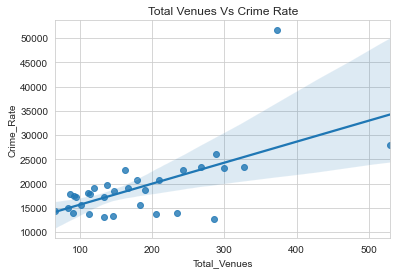

In [31]:
sns.regplot(x="Total_Venues", y="Crime_Rate", data=london1)
plt.ylim(0,)
plt.title('Total Venues Vs Crime Rate')

Text(0.5, 1.0, 'Art Venues Vs Crime Rate')

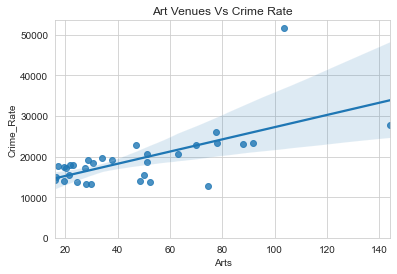

In [32]:
sns.regplot(x="Arts", y="Crime_Rate", data=london1)
plt.ylim(0,)
plt.title('Art Venues Vs Crime Rate')


Text(0.5, 1.0, 'Outdoor Recreation Venues Vs Crime Rate')

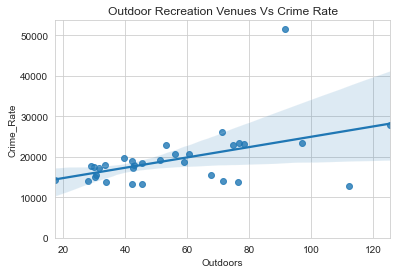

In [33]:
sns.regplot(x="Outdoors", y="Crime_Rate", data=london1)
plt.ylim(0,)
plt.title('Outdoor Recreation Venues Vs Crime Rate')

Text(0.5, 1.0, 'Study Venues Vs Crime Rate')

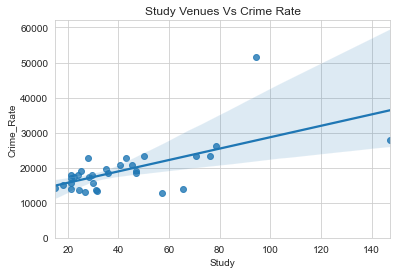

In [34]:
sns.regplot(x="Study", y="Crime_Rate", data=london1)
plt.ylim(0,)
plt.title('Study Venues Vs Crime Rate')

Text(0.5, 1.0, 'Social and Religious Venues Vs Crime Rate')

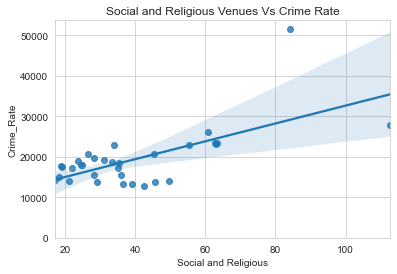

In [35]:
sns.regplot(x="Social and Religious", y="Crime_Rate", data=london1)
plt.ylim(0,)
plt.title('Social and Religious Venues Vs Crime Rate')

All appear to have positive correlations with crime rate, which is not at all what we expected!

### Pearson Correlation Test

The null hypothesis is that there is no correlation between the number of total venues, or the number of each type of venues, and crime rate.

The closer to 1 or -1 the correlation coefficient is, the larger the correlation is.

I have chosen a p value of 0.05, so p must be below that for the result to be statistically significant.

In [36]:
def calc_pearson(var):
    pearson_coef, p_value = scipy.stats.pearsonr(london1[var], london1['Crime_Rate'])
    print(f'The correlation coefficient for {var} with crime rate is {round(pearson_coef, 3)}, with a p-value of {round(p_value, 3)}')
    if p_value < 0.05:
        print('The correlation is statistically significant.')
    else:
        print('The correlation is not statistically significant.')

cols = ['Arts', 'Outdoors', 'Study', 'Social and Religious', 'Total_Venues']
for col in cols:
    calc_pearson(col)

The correlation coefficient for Arts with crime rate is 0.647, with a p-value of 0.0
The correlation is statistically significant.
The correlation coefficient for Outdoors with crime rate is 0.467, with a p-value of 0.007
The correlation is statistically significant.
The correlation coefficient for Study with crime rate is 0.629, with a p-value of 0.0
The correlation is statistically significant.
The correlation coefficient for Social and Religious with crime rate is 0.651, with a p-value of 0.0
The correlation is statistically significant.
The correlation coefficient for Total_Venues with crime rate is 0.619, with a p-value of 0.0
The correlation is statistically significant.


From these results, we **reject the null hypothesis**.

**There is a correlation between numbers of venues, and numbers of types of venues and crime rate.**

This correlation is **positive**, the more of each venue type, the higher the crime rate.

For all venue types, except outdoor recreation, the correlation coefficient is approximately 0.6.

For outdoor recreation, the correlation coefficient is lower at only approximately 0.5.

However, correlation is not causation!

### Preparing data for K-means Clustering

In [57]:
all_venues = pd.read_csv('all_venues.csv')  # so i don't have to redo the stuff above

# one hot encoding
london_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
london_onehot['Borough'] = all_venues['Borough']

# move borough column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Borough,Adult Education Center,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,...,Water Park,Waterfall,Waterfront,Weight Loss Center,Well,Windmill,Wine Bar,Yoga Studio,Zoo,Zoo Exhibit
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped

,Borough,Adult Education Center,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,...,Water Park,Waterfall,Waterfront,Weight Loss Center,Well,Windmill,Wine Bar,Yoga Studio,Zoo,Zoo Exhibit
0,Barking and Dagenham,0.000000,0.000000,0.00000,0.003195,0.028754,0.000000,0.00000,0.000000,0.003195,...,0.000000,0.000000,0.000000,0.000000,0.003195,0.000000,0.000000,0.000000,0.000000,0.003195
1,Barnet,0.003040,0.003040,0.00000,0.003040,0.009119,0.012158,0.00000,0.003040,0.021277,...,0.000000,0.000000,0.000000,0.003040,0.000000,0.000000,0.000000,0.006079,0.003040,0.003040
2,Bexley,0.000000,0.000000,0.00000,0.000000,0.010791,0.000000,0.00000,0.000000,0.010791,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003597
3,Brent,0.002740,0.002740,0.00000,0.002740,0.013699,0.016438,0.00000,0.000000,0.002740,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002740,0.002740,0.002740
4,Bromley,0.000000,0.000000,0.00000,0.000000,0.018265,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004566,0.000000,0.004566
5,Camden,0.001285,0.002571,0.00000,0.001285,0.028278,0.008997,0.00000,0.001285,0.002571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008997,0.001285,0.019280
6,Croydon,0.002833,0.002833,0.00000,0.000000,0.025496,0.011331,0.00000,0.000000,0.016997,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002833,0.002833,0.000000,0.000000
7,Ealing,0.002577,0.002577,0.00000,0.002577,0.010309,0.015464,0.00000,0.000000,0.015464,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002577,0.002577
8,Enfield,0.000000,0.000000,0.00000,0.000000,0.024221,0.000000,0.00000,0.000000,0.010381,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003460,0.003460,0.006920
9,Greenwich,0.002079,0.000000,0.00000,0.000000,0.035343,0.008316,0.00000,0.000000,0.006237,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008316,0.000000,0.002079


Find the top 10 venue categories per borough



In [59]:
# top 10 categories per borough

# function to find the top venues for each neighbourhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Boroughs_venues_sorted = pd.DataFrame(columns=columns)
Boroughs_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    Boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

Boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Church,Park,Social Club,College Academic Building,Library,General College & University,Gym / Fitness Center,University,Art Gallery,Community Center
1,Barnet,Church,Park,Library,General College & University,College Academic Building,Gym / Fitness Center,Plaza,Social Club,Garden,University
2,Bexley,Church,Park,Library,Historic Site,College Academic Building,Social Club,General College & University,Community Center,University,Gym / Fitness Center
3,Brent,Church,Park,Library,University,College Academic Building,College Classroom,Plaza,Golf Course,Historic Site,General Entertainment
4,Bromley,Church,Park,Historic Site,Library,College Academic Building,University,Community Center,Social Club,General College & University,Outdoor Sculpture


### Finding the correct value for k

#### Elbow method

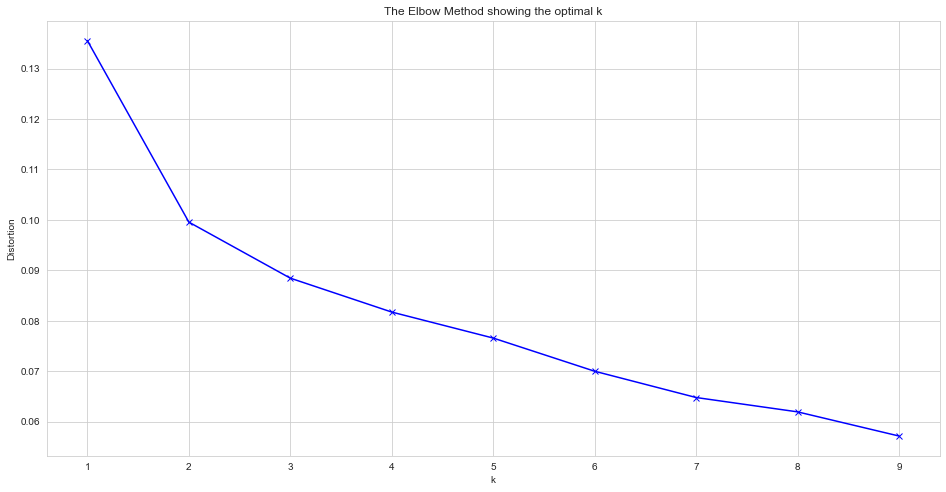

In [60]:
london_grouped_clustering = london_grouped.drop('Borough', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the elbow method, the correct value for k is 2.

In [61]:
# set number of clusters
kclusters = 2



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [62]:
# add clustering labels
Boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london2= london_crimes.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each Borough
london2 = london2.join(Boroughs_venues_sorted.set_index('Borough'), on='Borough')

london2.head()

,Borough,Population,longitude,latitude,Total_Crime,Crime_Rate,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,212906,0.129506,51.5455,39456,18532.12,1,Church,Park,Social Club,College Academic Building,Library,General College & University,Gym / Fitness Center,University,Art Gallery,Community Center
1,Barnet,395896,-0.218210,51.6111,59167,14945.09,1,Church,Park,Library,General College & University,College Academic Building,Gym / Fitness Center,Plaza,Social Club,Garden,University
2,Bexley,248287,0.146212,51.4582,33929,13665.23,1,Church,Park,Library,Historic Site,College Academic Building,Social Club,General College & University,Community Center,University,Gym / Fitness Center
3,Brent,329771,-0.275680,51.5644,59257,17969.14,1,Church,Park,Library,University,College Academic Building,College Classroom,Plaza,Golf Course,Historic Site,General Entertainment
4,Bromley,332336,0.039246,51.3727,47499,14292.46,1,Church,Park,Historic Site,Library,College Academic Building,University,Community Center,Social Club,General College & University,Outdoor Sculpture


### Examining and naming the clusters


#### Cluster 1: Fun London
This cluster has more art galleries, music venues, theatres and outdoor spaces like gardens and playgrounds

In [63]:
london2.loc[london2['Cluster Labels'] == 0, london2.columns[[0] + list(range(7, london2.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Camden,Church,Park,Plaza,University,Art Gallery,Library,Theater,Social Club,Gym / Fitness Center,Music Venue
9,Greenwich,Church,Park,College Academic Building,Library,University,Art Gallery,Gym / Fitness Center,Plaza,General College & University,Community Center
10,Hackney,Church,Park,Art Gallery,Gym / Fitness Center,Community Center,University,Library,Music Venue,Garden,Performing Arts Venue
11,Hammersmith and Fulham,Church,Park,Gym / Fitness Center,Art Gallery,General Entertainment,University,College Classroom,Garden,Gym,Historic Site
12,Haringey,Church,Park,Gym / Fitness Center,Music Venue,Historic Site,Library,University,Art Gallery,General Entertainment,Playground
17,Islington,Church,Park,Art Gallery,Music Venue,Library,General Entertainment,Gym / Fitness Center,Playground,General College & University,Garden
18,Kensington and Chelsea,Church,Art Gallery,Park,Gym / Fitness Center,Garden,College Academic Building,University,General College & University,Gym,Historic Site
20,Lambeth,Church,Park,Art Gallery,Gym / Fitness Center,Theater,Library,Social Club,University,Historic Site,Music Venue
21,Lewisham,Church,Park,Art Gallery,University,Library,Gym / Fitness Center,College Residence Hall,College Academic Building,General College & University,General Entertainment
23,Newham,Church,Park,Mosque,Gym / Fitness Center,University,Art Gallery,College Classroom,College Academic Building,General Entertainment,College Residence Hall


#### Cluster 2: Sensible London
This cluster has more gyms, sports clubs and academic buildings.

In [65]:
london2.loc[london2['Cluster Labels'] == 1, london2.columns[[0] + list(range(7, london2.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Church,Park,Social Club,College Academic Building,Library,General College & University,Gym / Fitness Center,University,Art Gallery,Community Center
1,Barnet,Church,Park,Library,General College & University,College Academic Building,Gym / Fitness Center,Plaza,Social Club,Garden,University
2,Bexley,Church,Park,Library,Historic Site,College Academic Building,Social Club,General College & University,Community Center,University,Gym / Fitness Center
3,Brent,Church,Park,Library,University,College Academic Building,College Classroom,Plaza,Golf Course,Historic Site,General Entertainment
4,Bromley,Church,Park,Historic Site,Library,College Academic Building,University,Community Center,Social Club,General College & University,Outdoor Sculpture
6,Croydon,Church,Park,Library,College Classroom,Theater,College Academic Building,Art Gallery,University,Community Center,Plaza
7,Ealing,Church,Park,Library,College Academic Building,University,Bridge,General College & University,Soccer Field,Gym / Fitness Center,General Entertainment
8,Enfield,Church,Park,Library,College Academic Building,General College & University,Art Gallery,Garden,University,Gym / Fitness Center,Tennis Court
13,Harrow,Church,Park,Library,College Academic Building,General College & University,Gym / Fitness Center,Mosque,General Entertainment,Spiritual Center,Soccer Stadium
14,Havering,Church,Park,College Academic Building,Library,Social Club,General College & University,College Classroom,Gym / Fitness Center,Music Venue,Other Great Outdoors


In [66]:
# add my names to the df
labels = {0: "Fun London", 1: "Sensible London"}

london2['Cluster Names'] = london2['Cluster Labels'].map(labels)
london2.head()


,Borough,Population,longitude,latitude,Total_Crime,Crime_Rate,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Names
0,Barking and Dagenham,212906,0.129506,51.5455,39456,18532.12,1,Church,Park,Social Club,College Academic Building,Library,General College & University,Gym / Fitness Center,University,Art Gallery,Community Center,Sensible London
1,Barnet,395896,-0.218210,51.6111,59167,14945.09,1,Church,Park,Library,General College & University,College Academic Building,Gym / Fitness Center,Plaza,Social Club,Garden,University,Sensible London
2,Bexley,248287,0.146212,51.4582,33929,13665.23,1,Church,Park,Library,Historic Site,College Academic Building,Social Club,General College & University,Community Center,University,Gym / Fitness Center,Sensible London
3,Brent,329771,-0.275680,51.5644,59257,17969.14,1,Church,Park,Library,University,College Academic Building,College Classroom,Plaza,Golf Course,Historic Site,General Entertainment,Sensible London
4,Bromley,332336,0.039246,51.3727,47499,14292.46,1,Church,Park,Historic Site,Library,College Academic Building,University,Community Center,Social Club,General College & University,Outdoor Sculpture,Sensible London


In [67]:
# save it locally for later
london2.to_csv('london2.csv', index=False)

### Mapping the crime rate and clusters

In [68]:
london_geox = gpd.read_file('gb_boroughs.json')
# London's starting coords from google
london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

In [ ]:
# dividing the crime rate into 3 bins, low, medium and high

bins = list(london2["Crime_Rate"].quantile([0, 1/3, 2/3, 1]))

folium.Choropleth(
    geo_data=london_geox,
    data=london2,
    columns=['Borough', 'Crime_Rate'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.4,
    line_opacity=0.5,
    bins=bins,
    nan_fill_color='black',
    nan_fill_opacity=0.7,
    legend_name='Crime Rates in London'
).add_to(london_map)

### London Map showing crime rates

In [69]:
# london_map


#### Adding categories to map



In [70]:
# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, name in zip(london2['latitude'], london2['longitude'], london2['Borough'], london2['Cluster Labels'], london2['Cluster Names']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_map)

### London Map, with crime rate and markers showing borough category


In [71]:
# london_map

As you can see from the map, I might as well have named the clusters Inner and Outer London!

However, there does seem to be some correlation with crime rates, so I will do a test to be sure.

As there are only two clusters, I will do a T test.

The null hypothesis is that there is no difference between the mean crime rates for the two clusters.

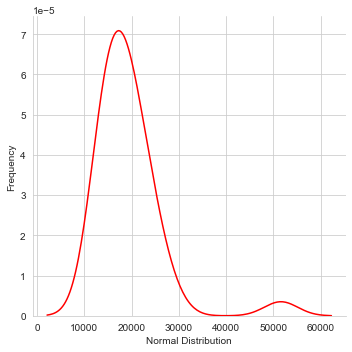

In [77]:
# Check for normal(ish) distribution
ax = sns.displot(london_crimes['Crime_Rate'],
                  kind="kde",
                  color='red')
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

In [79]:
# do levene's test of equal variance to check for, um, equal variance!
group1 = london2.loc[london2['Cluster Labels'] == 0, 'Crime_Rate']
group2 = london2.loc[london2['Cluster Labels'] == 1, 'Crime_Rate']

scipy.stats.levene(group1, group2, center='mean')

LeveneResult(statistic=2.7959206922869164, pvalue=0.10490417325634456)

In [80]:
# as p > 0.05, variances are equal
# Finally, the t test!
scipy.stats.ttest_ind(group1, group2, equal_var=True)


Ttest_indResult(statistic=3.3774381946559893, pvalue=0.0020411064947291136)

As p < 0.05, we **reject** the null hypothesis.

**There is a difference between the mean crime rates of the clusters.**

From the map 'Fun London' has a higher crime rate than 'Sensible London'.

## Results and Discussion <a name="results"></a>

From our results and tests, we have shown relationships between both the number of venues and the types of venues, and crime rates in the area.

There is a positive correlation between the total number of venues, and the number of each type of venues per capita, and the crime rate.

But, this does not mean that to lower crime rates we should be tearing down our amenities.

**Correlation does not equal causation!**

Just because I have shown two things are correlated, it does not mean that one thing caused the other.

In this case, I would say it is highly unlikely to be true.

While it was interesting to try this approach, there are many other factors that impact on crime rates, such as poverty or drug use.

It may also be my list of venues was too broad, and I really needed to be able to focus on places intended for young people such as community centres or youth clubs, which was not possible at this time. Perhaps I also needed to focus more specifically on the types of crime committed by younger people. Were stakeholders interested in repeating this study, that is how I would set it up in the future.

I also found a correlation between the types of venues in Fun London (more music venues, theatres and art galleries) and a higher crime rate, and between the types of venues in Sensible London (Gyms, Sports Fields and Study types) and lower crime rates.

In this case correlation may indeed be causation! But not quite in the way the study meant.

Rather than providing 'things to do', these 'fun' venues are more likely attracting visitors from outside the area, and in central London, which is all in 'Fun London', many tourists.

Tourists are more likely to be victims of crimes, as are people slightly the worse for wear at music venues and theatres!

Perhaps to reduce crime, without tearing down venues providing income, patrols in these areas need to be increased.



## Conclusion <a name="results"></a>

The main lesson from this is that causes behind crime rates are more complicated than can be easily discovered by simply looking at one factor.

Should stakeholders wish to investigate further, I would suggest refining the study to specific types of venues most suitable for young people, and those types of crime committed mostly by young people.
